## MSD script

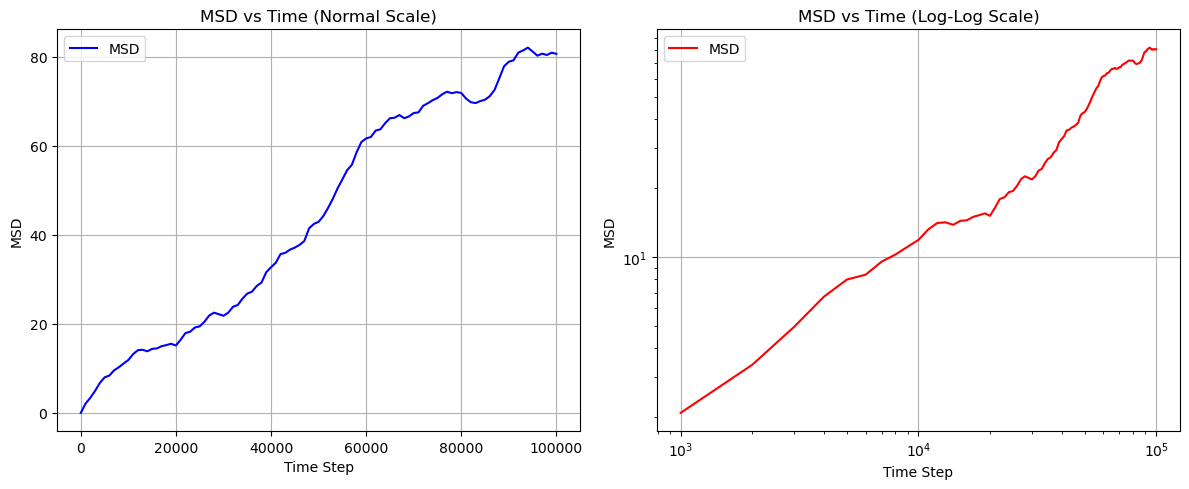

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Function to read data from file
def read_data(filename):
    time_steps, msd_values = [], []
    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#') and line.strip():
                timestep, msd = map(float, line.split())
                time_steps.append(timestep)
                msd_values.append(msd)
    return np.array(time_steps), np.array(msd_values)

# Read data
time_steps, msd_values = read_data(r'C:\Users\nande\Desktop\mtp\msd_all.dat')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot MSD in normal scale
ax1.plot(time_steps, msd_values, 'b-', label='MSD')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('MSD')
ax1.set_title('MSD vs Time (Normal Scale)')
ax1.legend()
ax1.grid(True)

# Plot MSD in log-log scale
ax2.loglog(time_steps[1:], msd_values[1:], 'r-', label='MSD')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('MSD')
ax2.set_title('MSD vs Time (Log-Log Scale)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Rg script

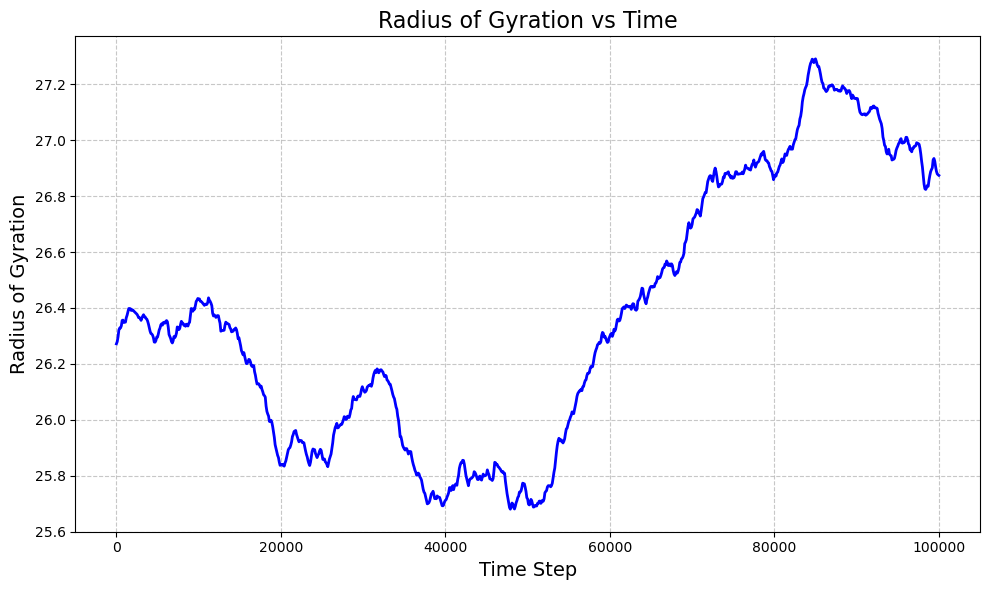

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = np.loadtxt(r'C:\Users\nande\Desktop\mtp\case_3_charged\24_5\rg_all.dat', skiprows=2)  # Skip the header rows
timesteps = data[:, 0]
rg_values = data[:, 1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, rg_values, 'b-', linewidth=2)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Radius of Gyration', fontsize=14)
plt.title('Radius of Gyration vs Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.show()

## coulumbic

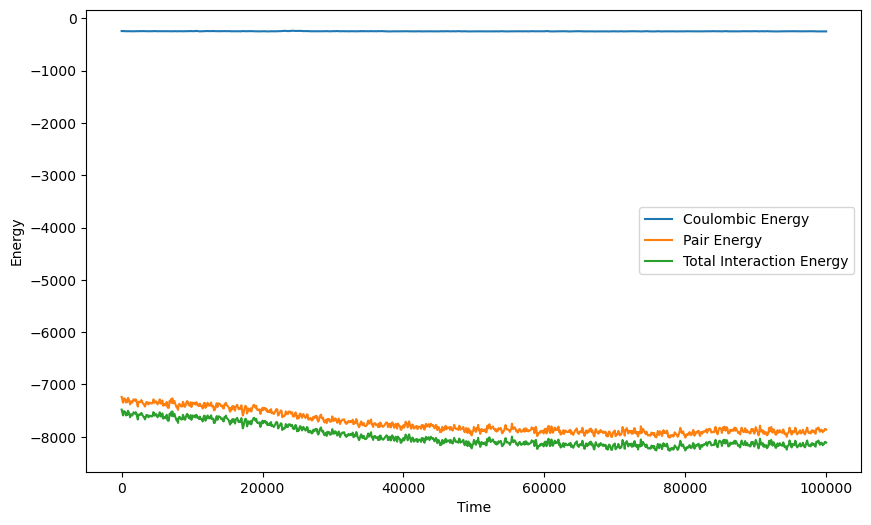

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = np.loadtxt(r'C:\Users\nande\Desktop\mtp\case_3_charged\24_5\coulombic.dat', skiprows=1)  # Skip header

# Extract columns
time = data[:, 0]
coul_energy = data[:, 1]
pair_energy = data[:, 2]
total_charge = data[:, 3]

# Plot energies
plt.figure(figsize=(10, 6))
plt.plot(time, coul_energy, label='Coulombic Energy')
plt.plot(time, pair_energy, label='Pair Energy')
plt.plot(time, coul_energy + pair_energy, label='Total Interaction Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()

## Domain analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import networkx as nx
from scipy import signal
import os

def read_lammps_dump(filename, frame_number=0):
    """
    Read a LAMMPS dump file and extract data from a specific frame
    
    Parameters:
    -----------
    filename : str
        Path to the LAMMPS dump file
    frame_number : int
        Index of the frame to extract (starting from 0)
        
    Returns:
    --------
    data : numpy array
        Array with atom data (id, type, charge, x, y, z, cluster_id)
    box : list of tuples
        List containing box dimensions [(xlo, xhi), (ylo, yhi), (zlo, zhi)]
    timestep : int
        Timestep of the frame
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Find frame locations
    frame_locations = []
    for i, line in enumerate(lines):
        if line.startswith("ITEM: TIMESTEP"):
            frame_locations.append(i)
    
    if frame_number >= len(frame_locations):
        raise ValueError(f"Frame {frame_number} not found. File has {len(frame_locations)} frames.")
    
    # Get starting line for the desired frame
    start_line = frame_locations[frame_number]
    
    # Get timestep
    timestep = int(lines[start_line + 1].strip())
    
    # Get number of atoms
    n_atoms = int(lines[start_line + 3].strip())
    
    # Get box bounds
    xlo, xhi = map(float, lines[start_line + 5].split()[:2])
    ylo, yhi = map(float, lines[start_line + 6].split()[:2])
    zlo, zhi = map(float, lines[start_line + 7].split()[:2])
    box = [(xlo, xhi), (ylo, yhi), (zlo, zhi)]
    
    # Get column headers
    header_line = lines[start_line + 8]
    headers = header_line.split()[2:]  # Skip "ITEM: ATOMS"
    
    # Read atom data
    data = np.zeros((n_atoms, len(headers)))
    
    for i in range(n_atoms):
        line = lines[start_line + 9 + i].split()
        data[i] = np.array([float(x) for x in line])
    
    return data, box, timestep

def analyze_clusters(data):
    """
    Analyze cluster statistics from LAMMPS dump file with cluster IDs
    
    Parameters:
    -----------
    data : numpy array
        Array with atom data including cluster IDs
        
    Returns:
    --------
    cluster_stats : dict
        Dictionary with cluster statistics
    """
    # Extract cluster IDs (assuming last column is cluster ID)
    cluster_ids = data[:, -1]
    atom_types = data[:, 1]  # Assuming type is second column
    
    # Count unique clusters
    unique_clusters = np.unique(cluster_ids)
    n_clusters = len(unique_clusters)
    
    # Analyze each cluster
    cluster_sizes = []
    cluster_compositions = []
    
    for c_id in unique_clusters:
        # Skip cluster 0 (typically unassigned atoms)
        if c_id == 0:
            continue
            
        # Get atoms in this cluster
        cluster_atoms = data[cluster_ids == c_id]
        cluster_size = len(cluster_atoms)
        cluster_sizes.append(cluster_size)
        
        # Get composition
        type_a_count = np.sum(cluster_atoms[:, 1] == 1)
        type_b_count = np.sum(cluster_atoms[:, 1] == 2)
        cluster_compositions.append((type_a_count, type_b_count))
    
    # Compute statistics
    if cluster_sizes:
        avg_size = np.mean(cluster_sizes)
        max_size = np.max(cluster_sizes)
        num_clusters = len(cluster_sizes)
        size_distribution = np.bincount(cluster_sizes)
    else:
        avg_size = 0
        max_size = 0
        num_clusters = 0
        size_distribution = np.array([])
    
    cluster_stats = {
        "num_clusters": num_clusters,
        "avg_size": avg_size,
        "max_size": max_size,
        "size_distribution": size_distribution,
        "cluster_sizes": cluster_sizes,
        "cluster_compositions": cluster_compositions
    }
    
    return cluster_stats

def calculate_domain_size(data, box, grid_size=40):
    """
    Calculate domain size using spatial correlation function
    
    Parameters:
    -----------
    data : numpy array
        Array with atom data
    box : list of tuples
        List containing box dimensions [(xlo, xhi), (ylo, yhi), (zlo, zhi)]
    grid_size : int
        Number of grid points in each dimension
        
    Returns:
    --------
    domain_size : float
        Characteristic domain size
    correlation_profile : numpy array
        Correlation function values
    radii : numpy array
        Radii for correlation function
    """
    # Extract positions and types
    positions = data[:, 3:6]  # Assuming x, y, z are columns 3-5
    types = data[:, 1]        # Assuming type is column 1
    
    # Create 3D grid
    x_edges = np.linspace(box[0][0], box[0][1], grid_size + 1)
    y_edges = np.linspace(box[1][0], box[1][1], grid_size + 1)
    z_edges = np.linspace(box[2][0], box[2][1], grid_size + 1)
    
    # Count type A atoms in each grid cell
    hist_a, _ = np.histogramdd(positions[types == 1], bins=[x_edges, y_edges, z_edges])
    
    # Count type B atoms in each grid cell
    hist_b, _ = np.histogramdd(positions[types == 2], bins=[x_edges, y_edges, z_edges])
    
    # Calculate order parameter field (normalized difference)
    total = hist_a + hist_b
    mask = total > 0
    order_param = np.zeros_like(hist_a)
    order_param[mask] = (hist_a[mask] - hist_b[mask]) / total[mask]
    
    # Compute autocorrelation function
    autocorr = signal.fftconvolve(order_param, order_param[::-1,::-1,::-1], mode='full')
    
    # Extract radial profile
    center = autocorr.shape[0] // 2
    max_radius = min(autocorr.shape) // 2
    radii = np.arange(1, max_radius)
    profile = np.zeros_like(radii, dtype=float)
    
    for i, r in enumerate(radii):
        # Extract shell at radius r
        x, y, z = np.ogrid[-center:center+1, -center:center+1, -center:center+1]
        mask = (x**2 + y**2 + z**2 >= r**2) & (x**2 + y**2 + z**2 < (r+1)**2)
        profile[i] = np.mean(autocorr[mask])
    
    # Normalize
    profile = profile / profile[0]
    
    # Find first minimum (domain size)
    for i in range(1, len(profile)-1):
        if profile[i] < profile[i-1] and profile[i] < profile[i+1]:
            first_min = i
            break
    else:
        # If no minimum is found, use the half-height
        first_min = np.argmin(np.abs(profile - 0.5))
    
    # Calculate real-space distance
    grid_spacing = (box[0][1] - box[0][0]) / grid_size
    domain_size = first_min * grid_spacing
    
    return domain_size, profile, radii * grid_spacing

def calculate_structure_factor(data, box, q_max=10.0, n_bins=50):
    """
    Calculate structure factor S(q)
    
    Parameters:
    -----------
    data : numpy array
        Array with atom data
    box : list of tuples
        List containing box dimensions [(xlo, xhi), (ylo, yhi), (zlo, zhi)]
    q_max : float
        Maximum q vector magnitude
    n_bins : int
        Number of q vector magnitude bins
        
    Returns:
    --------
    q_values : numpy array
        Array of q vector magnitudes
    s_q : numpy array
        Structure factor values
    """
    # Extract positions
    positions = data[:, 3:6]  # Assuming x, y, z are columns 3-5
    n_particles = len(positions)
    
    # Create q bins
    q_values = np.linspace(0.1, q_max, n_bins)
    s_q = np.zeros(n_bins)
    
    # Normalize positions to box size
    box_size = np.array([box[i][1] - box[i][0] for i in range(3)])
    positions_norm = positions.copy()
    for i in range(3):
        positions_norm[:, i] = 2 * np.pi * positions[:, i] / box_size[i]
    
    # Calculate S(q) by averaging over random q directions
    n_directions = 30
    
    for i, q in enumerate(q_values):
        sq_partial = 0
        
        for _ in range(n_directions):
            # Generate random unit vector
            phi = 2 * np.pi * np.random.random()
            cos_theta = 2 * np.random.random() - 1
            sin_theta = np.sqrt(1 - cos_theta**2)
            
            qx = q * sin_theta * np.cos(phi)
            qy = q * sin_theta * np.sin(phi)
            qz = q * cos_theta
            q_vec = np.array([qx, qy, qz])
            
            # Calculate S(q) for this direction
            cos_sum = 0
            sin_sum = 0
            
            for pos in positions_norm:
                dot_product = np.dot(pos, q_vec)
                cos_sum += np.cos(dot_product)
                sin_sum += np.sin(dot_product)
                
            sq_partial += (cos_sum**2 + sin_sum**2) / n_particles
            
        s_q[i] = sq_partial / n_directions
    
    return q_values, s_q

def analyze_trajectory(dump_file, output_dir="analysis_results"):
    """
    Analyze a trajectory file for cluster and domain statistics
    
    Parameters:
    -----------
    dump_file : str
        Path to the LAMMPS dump file
    output_dir : str
        Directory to save analysis results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Count total frames
    with open(dump_file, 'r') as f:
        total_frames = sum(1 for line in f if line.startswith("ITEM: TIMESTEP"))
    
    # Define which frames to analyze (skip some for efficiency)
    frames_to_analyze = range(0, total_frames, max(1, total_frames // 20))
    
    # Initialize results arrays
    timesteps = []
    max_cluster_sizes = []
    num_clusters = []
    domain_sizes = []
    
    # Process each frame
    for frame in frames_to_analyze:
        print(f"Processing frame {frame} of {total_frames}...")
        
        # Read data
        data, box, timestep = read_lammps_dump(dump_file, frame)
        
        # Analyze clusters
        cluster_stats = analyze_clusters(data)
        
        # Calculate domain size
        domain_size, corr_profile, corr_radii = calculate_domain_size(data, box)
        
        # Calculate structure factor
        q_values, s_q = calculate_structure_factor(data, box)
        
        # Store results
        timesteps.append(timestep)
        max_cluster_sizes.append(cluster_stats['max_size'])
        num_clusters.append(cluster_stats['num_clusters'])
        domain_sizes.append(domain_size)
        
        # Save frame-specific data
        if frame % 5 == 0:  # Save less frequently to reduce files
            # Save correlation profile
            corr_data = np.column_stack((corr_radii, corr_profile))
            np.savetxt(f"{output_dir}/correlation_frame{frame}.dat", corr_data,
                      header="Distance Correlation", comments="# ")
            
            # Save structure factor
            sf_data = np.column_stack((q_values, s_q))
            np.savetxt(f"{output_dir}/structure_factor_frame{frame}.dat", sf_data,
                      header="q S(q)", comments="# ")
    
    # Save time series data
    time_series = np.column_stack((timesteps, max_cluster_sizes, num_clusters, domain_sizes))
    np.savetxt(f"{output_dir}/time_series.dat", time_series, 
              header="Timestep MaxClusterSize NumClusters DomainSize", comments="# ")
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(timesteps, max_cluster_sizes, 'o-')
    plt.xlabel('Timestep')
    plt.ylabel('Maximum Cluster Size')
    plt.title('Cluster Growth')
    
    plt.subplot(2, 2, 2)
    plt.plot(timesteps, domain_sizes, 'o-')
    plt.xlabel('Timestep')
    plt.ylabel('Domain Size')
    plt.title('Domain Growth')
    
    plt.subplot(2, 2, 3)
    plt.plot(timesteps, num_clusters, 'o-')
    plt.xlabel('Timestep')
    plt.ylabel('Number of Clusters')
    plt.title('Cluster Count')
    
    plt.subplot(2, 2, 4)
    # Plot structure factor for the last frame
    plt.plot(q_values, s_q)
    plt.xlabel('q')
    plt.ylabel('S(q)')
    plt.title('Structure Factor (Final Frame)')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/cluster_domain_analysis.png", dpi=300)
    
    return {
        'timesteps': timesteps,
        'max_cluster_sizes': max_cluster_sizes,
        'num_clusters': num_clusters,
        'domain_sizes': domain_sizes
    }

def plot_rdf_analysis(rdf_file, output_dir="analysis_results"):
    """
    Plot RDF data from LAMMPS output
    
    Parameters:
    -----------
    rdf_file : str
        Path to the RDF data file from LAMMPS
    output_dir : str
        Directory to save analysis results
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Read the file and skip header lines
    with open(rdf_file, 'r') as f:
        lines = f.readlines()
    
    # Skip the first 3 lines (comments and headers)
    data_lines = lines[4:]  # Skip the first 4 lines (3 comment lines + timestep line)
    
    # Parse the data
    r_values = []
    rdf_aa = []
    rdf_bb = []
    rdf_ab = []
    
    for line in data_lines:
        values = line.strip().split()
        if len(values) >= 10:  # Ensure we have enough columns
            r_values.append(float(values[0]))
            rdf_aa.append(float(values[1]))
            rdf_bb.append(float(values[4]))
            rdf_ab.append(float(values[7]))
    
    # Plot RDFs
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, rdf_aa, '-', label='A-A')
    plt.plot(r_values, rdf_bb, '-', label='B-B')
    plt.plot(r_values, rdf_ab, '-', label='A-B')
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.legend()
    plt.title('Radial Distribution Functions')
    plt.savefig(f"{output_dir}/rdf_analysis.png", dpi=300)

def main():
    # Path to production trajectory
    dump_file = "production.lammpstrj"
    
    # Path to RDF data - update to the correct path
    rdf_file = "24_5/rdf_analysis.dat"
    
    # Output directory
    output_dir = "domain_analysis"
    
    # Analyze trajectory
    print("Starting trajectory analysis...")
    results = analyze_trajectory(dump_file, output_dir)
    
    # Plot RDF data
    print("Analyzing RDF data...")
    plot_rdf_analysis(rdf_file, output_dir)
    
    print(f"Analysis complete. Results saved to {output_dir}")

if __name__ == "__main__":
    main()